## Time Series Modeling -  Hourly Water Consumption Forecasting in the Greater Stuttgart
Landeswasserversorgung

In [1]:
# Import Packages
import numpy as np
import pandas as pd
import math

# statistics
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pmd  # for auto_arima

# missing data
from statsmodels.imputation.mice import MICEData  # for MICE imputation
import missingno as msno  # for missing data visualization

# sunrise data for Stuttgart
from astral import LocationInfo
from astral.sun import sun
from datetime import datetime, timedelta
import pytz  # Import timezone library

# plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns  # for correlation matrix

# read data
import json
import holidays
import warnings


# own functions
from utils.sarima_forecast import (
    train_and_forecast_sarima,
)  # for SARIMA model training and forecasting
from utils.fourier import fourier_series


# Prophet
from prophet import Prophet
from prophet.utilities import regressor_coefficients  # regression coefficients
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


### 1.) Load Data

#### 1.1.) Read in water demand data
Water demand from the Landeswasserversorgung at hourly level in l/s

In [2]:
df_hourly_water_demand = pd.read_csv(
    "../data/water_demand/prepared_water_demand_data.csv", parse_dates=["datetime"]
)
# df_hourly_water_demand = df_hourly_water_demand.set_index("datetime")
df_hourly_water_demand = df_hourly_water_demand[
    (df_hourly_water_demand["datetime"] < "2024-01-01")
    & (df_hourly_water_demand["datetime"] >= "2017-01-01")
]  # select data from 2017 onwards
df_hourly_water_demand.head(5)

nodal_demand  n_nodal_datapoints_available            datetime
25   3108.049187                          29.0 2017-01-01 00:00:00
26   2660.664133                          29.0 2017-01-01 01:00:00
27   2733.942179                          29.0 2017-01-01 02:00:00
28   1774.439187                          29.0 2017-01-01 03:00:00
29   1963.201523                          29.0 2017-01-01 04:00:00

##### 1.1.1.) Deal with missing data


In [3]:
# number of missing datapoints
print(
    "Number of missing data points:",
    df_hourly_water_demand["nodal_demand"].isna().sum(),
)

Number of missing data points: 7


In [4]:
# Fill missing values with the previous value
df_hourly_water_demand = df_hourly_water_demand.fillna(method="ffill")

#### 1.2.) Read in weather and holiday data
Weather data from the DWD stations Stuttgart-Schnarrenberg and Stuttgart-Echterdingen

In [5]:
df_weather = pd.read_csv(
    "../data/weather_climate/prepared_weather_data.csv", parse_dates=["datetime"]
)
df_weather = df_weather[
    (df_weather["datetime"] >= "2017-01-01") & (df_weather["datetime"] < "2024-01-01")
]  # select data from 2017 onwards
df_weather.head(5)

datetime  temperature_Schnar  temperature_Echt  \
346295 2017-01-01 00:00:00                -6.1              -6.7   
346296 2017-01-01 01:00:00                -6.3              -7.7   
346297 2017-01-01 02:00:00                -5.8              -7.3   
346298 2017-01-01 03:00:00                -5.8              -7.6   
346299 2017-01-01 04:00:00                -5.9              -8.3   

        sunshine_duration_Schnar  sunshine_duration_Echt  \
346295                       NaN                     NaN   
346296                       NaN                     NaN   
346297                       NaN                     NaN   
346298                       0.0                     0.0   
346299                       0.0                     0.0   

        precipitation_Schnar  precipitation_Echt  BF10  BF20  BF30  BF40  \
346295                   0.0                 0.0  80.0  80.0  81.0  82.0   
346296                   0.0                 0.0  80.0  80.0  81.0  82.0   
346297                   0.0                 0.0  80.0  80.0  81.0  82.0   
346298                   0.0                 0.0  80.0  80.0  81.0  82.0   
346299                   0.0                 0.0  80.0  80.0  81.0  82.0   

        BF50  BF60  
346295  84.0  87.0  
346296  84.0  87.0  
346297  84.0  87.0  
346298  84.0  87.0  
346299  84.0  87.0

##### 1.2.1.) Deal with missing data
Probably due to maintaince issues a "Missing at Random" (MAR) mechansim is given for the weather data, for both weather stations. Multiple Imputation (MI) is considered to impute missing data.

In [6]:
missing_counts = df_weather.isna().sum() / df_weather.shape[0]
print(missing_counts)

datetime                    0.000000
temperature_Schnar          0.002168
temperature_Echt            0.030940
sunshine_duration_Schnar    0.252233
sunshine_duration_Echt      0.310413
precipitation_Schnar        0.000897
precipitation_Echt          0.000587
BF10                        0.000000
BF20                        0.000000
BF30                        0.000000
BF40                        0.000000
BF50                        0.000000
BF60                        0.000000
dtype: float64


Most data missing for sunshine duration. Impute zeros if time is during night. Use astral package for day specific info on sunrise and sunset

In [7]:
# Define location (Stuttgart, Germany)
stuttgart = LocationInfo(
    name="Stuttgart",
    region="Germany",
    latitude=48.7758,
    longitude=9.1829,
    timezone="None",
)

In [8]:
# Function to determine whether the full hour is at night
def is_fully_nighttime(dt):
    s = sun(stuttgart.observer, date=dt.date(), tzinfo=None)

    # Convert sunrise/sunset times to the same timezone as df["datetime"]
    sunrise = s["sunrise"].replace(tzinfo=None)
    sunset = s["sunset"].replace(tzinfo=None)

    hour_start = dt
    hour_end = dt + timedelta(hours=1)

    # Set to zero ONLY if the whole hour is before sunrise or after sunset
    return hour_end <= sunrise or hour_start >= sunset

In [9]:
# Apply function to set sunshine duration to zero only when the full hour is at night
df_weather.loc[
    df_weather["datetime"].apply(is_fully_nighttime),
    ["sunshine_duration_Schnar", "sunshine_duration_Echt"],
] = 0

In [10]:
missing_counts = df_weather.isna().sum() / df_weather.shape[0]
print(missing_counts)

datetime                    0.000000
temperature_Schnar          0.002168
temperature_Echt            0.030940
sunshine_duration_Schnar    0.010792
sunshine_duration_Echt      0.051725
precipitation_Schnar        0.000897
precipitation_Echt          0.000587
BF10                        0.000000
BF20                        0.000000
BF30                        0.000000
BF40                        0.000000
BF50                        0.000000
BF60                        0.000000
dtype: float64


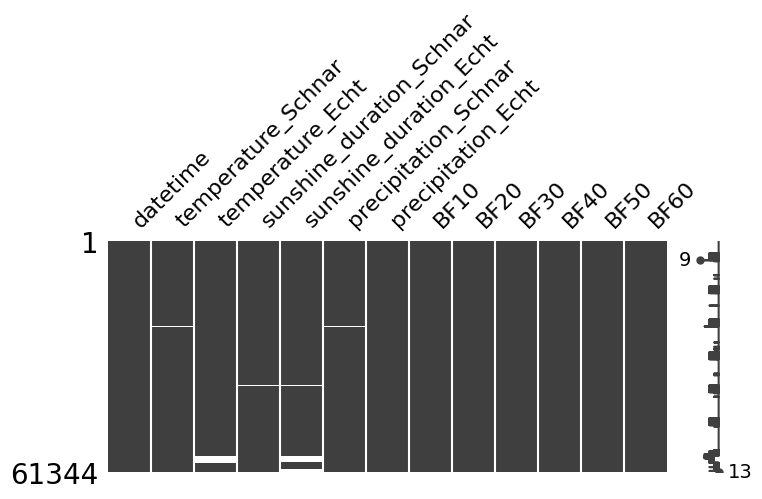

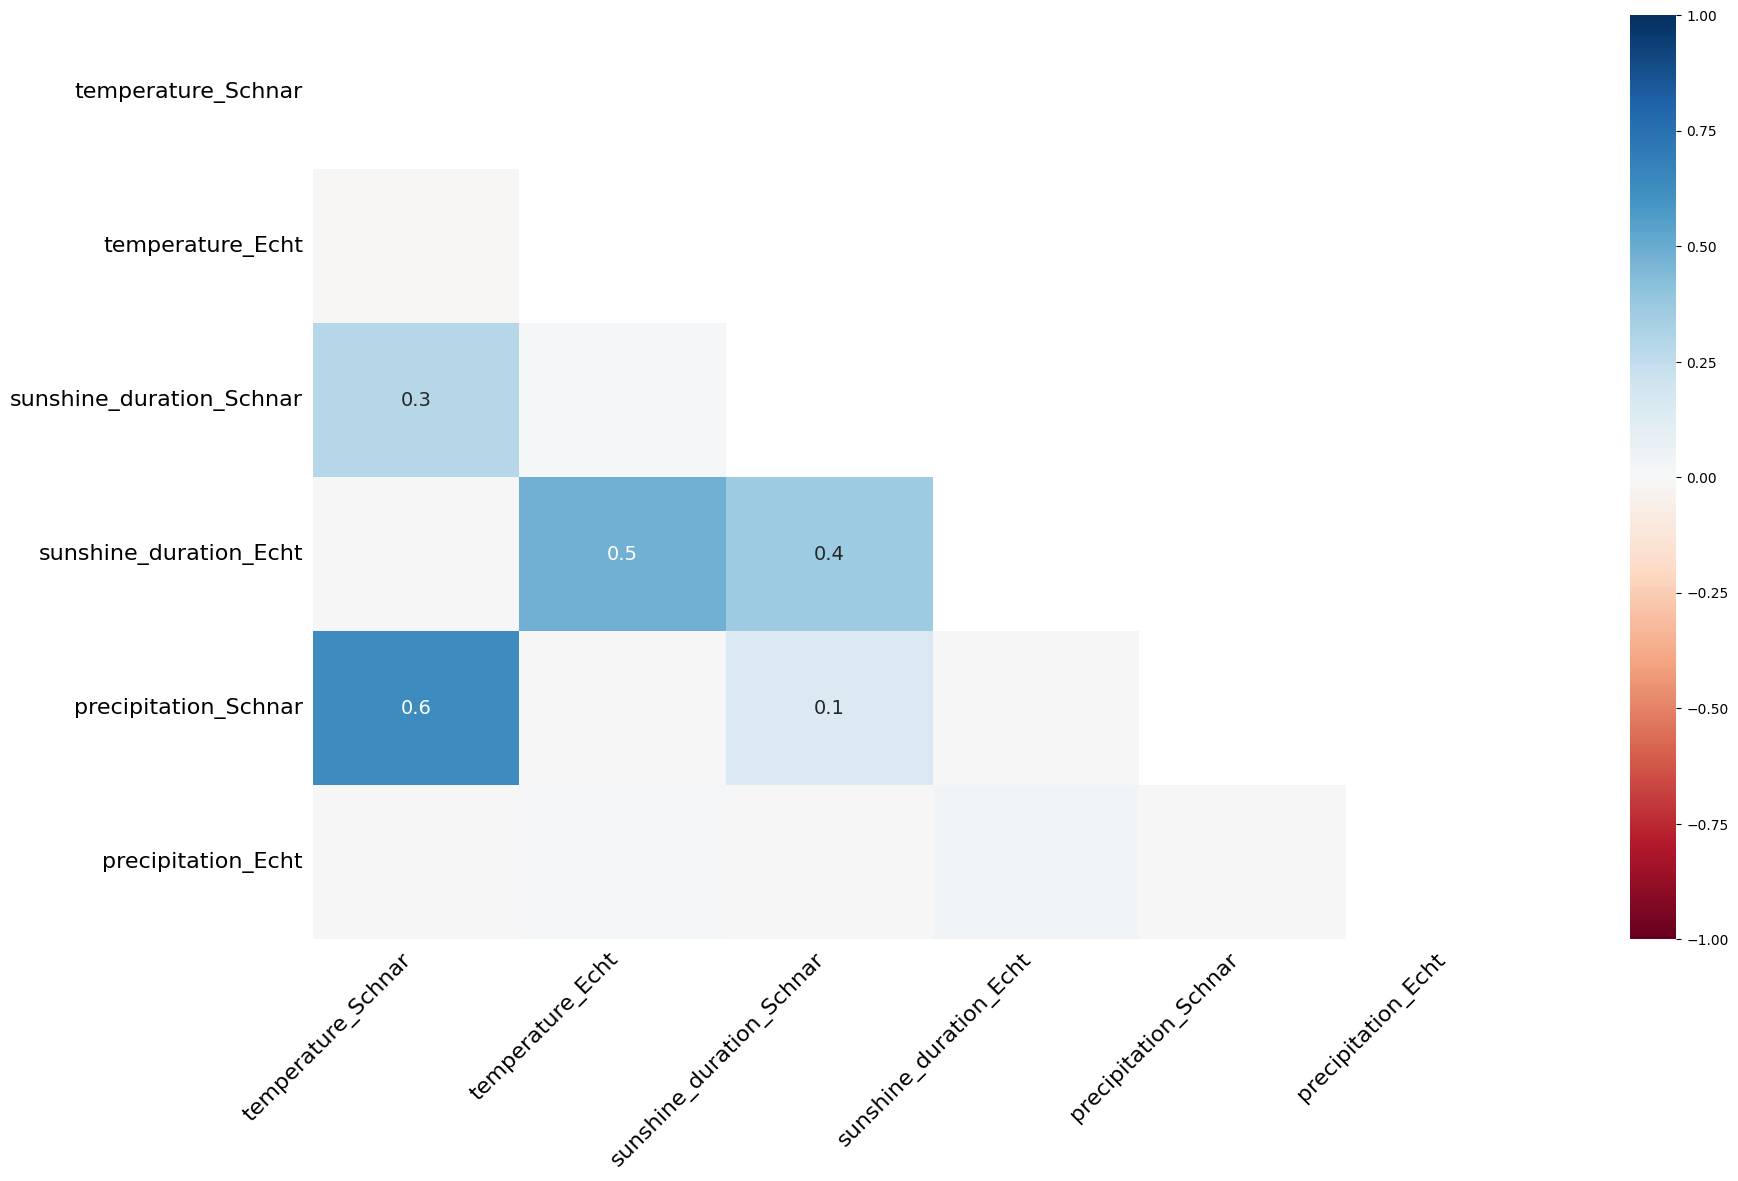

In [11]:
# Optional: Visualize missingness
msno.matrix(df_weather, figsize=(8, 3))
msno.heatmap(df_weather)
plt.show()

In [12]:
# Slice data for smaller memory
# Select columns that do NOT contain "BF" in their name
cols_to_impute = [
    col for col in df_weather.columns if "BF" not in col and "datetime" not in col
]

In [13]:
## Conduct multiple imputation using MICE
# Reduce dataset and lower precision
df_weather_reduced = df_weather[cols_to_impute].astype("float32")

# Initialize MICEData object
mice_data = MICEData(df_weather_reduced)

# Impute missing values
mice_data.update_all()

# Check imputed dataset
weather_imputed = mice_data.data.copy()
weather_imputed.index = df_weather.index  # Reassign the original index
weather_imputed.head(5)

temperature_Schnar  temperature_Echt  sunshine_duration_Schnar  \
346295                -6.1              -6.7                       0.0   
346296                -6.3              -7.7                       0.0   
346297                -5.8              -7.3                       0.0   
346298                -5.8              -7.6                       0.0   
346299                -5.9              -8.3                       0.0   

        sunshine_duration_Echt  precipitation_Schnar  precipitation_Echt  
346295                     0.0                   0.0                 0.0  
346296                     0.0                   0.0                 0.0  
346297                     0.0                   0.0                 0.0  
346298                     0.0                   0.0                 0.0  
346299                     0.0                   0.0                 0.0

In [ ]:
df_weather.update(
    weather_imputed, join="left", overwrite=True
)  # update the original df with imputed data

#### 1.3.) Add holiday data
Add holiday data for the state of Baden-Württemberg 

In [15]:
bw_holidays = holidays.country_holidays(
    years=np.arange(2017, 2024), country="DE", subdiv="BW"
)
bw_holidays.keys()

dict_keys([datetime.date(2017, 1, 1), datetime.date(2017, 4, 14), datetime.date(2017, 4, 17), datetime.date(2017, 5, 1), datetime.date(2017, 5, 25), datetime.date(2017, 6, 5), datetime.date(2017, 10, 3), datetime.date(2017, 12, 25), datetime.date(2017, 12, 26), datetime.date(2017, 10, 31), datetime.date(2017, 1, 6), datetime.date(2017, 6, 15), datetime.date(2017, 11, 1), datetime.date(2018, 1, 1), datetime.date(2018, 3, 30), datetime.date(2018, 4, 2), datetime.date(2018, 5, 1), datetime.date(2018, 5, 10), datetime.date(2018, 5, 21), datetime.date(2018, 10, 3), datetime.date(2018, 12, 25), datetime.date(2018, 12, 26), datetime.date(2018, 1, 6), datetime.date(2018, 5, 31), datetime.date(2018, 11, 1), datetime.date(2019, 1, 1), datetime.date(2019, 4, 19), datetime.date(2019, 4, 22), datetime.date(2019, 5, 1), datetime.date(2019, 5, 30), datetime.date(2019, 6, 10), datetime.date(2019, 10, 3), datetime.date(2019, 12, 25), datetime.date(2019, 12, 26), datetime.date(2019, 1, 6), datetime.date

In [16]:
# Create holiday object for Germany, specifically for Baden-Württemberg (BW)
bw_holidays = holidays.Germany(years=np.arange(2018, 2024), subdiv="BW")

# Extract holiday dates as a list of datetime.date objects
holiday_dates = list(bw_holidays.keys())

# Read in holiday data for Bade-Württemberg - set as binary variable
df_hourly_water_demand["is_holiday"] = (
    df_hourly_water_demand["datetime"].dt.date.isin(holiday_dates).astype(int)
)

In [17]:
df_merged = pd.merge(
    df_hourly_water_demand,
    df_weather[
        [
            "datetime",
            "temperature_Schnar",
            "sunshine_duration_Schnar",
            "precipitation_Schnar",
            "BF10",
            "BF20",
            "BF30",
            "BF40",
            "BF50",
            "BF60",
        ]
    ],
    on="datetime",
    how="outer",
)
df_merged["T_hot"] = np.maximum(
    df_merged["temperature_Schnar"] - 25, 0
)  # add variable which start from 25 degrees onwards
df_merged["T_very_hot"] = np.maximum(
    df_merged["temperature_Schnar"] - 30, 0
)  # add variable which start from 30 degrees onwards

df_merged["T_hot^2"] = (
    df_merged["T_hot"] ** 2
)  # Create squared term for hot temperature to consider non-linear effects

# Add a column to indicate whether the day is a working day or a weekend
df_merged = df_merged.set_index("datetime")
df_merged["day_of_week"] = df_merged.index.dayofweek
df_merged["is_weekend"] = (df_merged["day_of_week"] >= 5).astype(int)

In [18]:
# Add total sunshine duration per day, indicator for days above 25 and above 30 degrees
my_index = df_merged.index.copy()
df_merged["date"] = df_merged.index.date

# Step 1: Aggregate to daily level
sunshine_daily = (
    df_merged.groupby("date")["sunshine_duration_Schnar"].sum().reset_index()
)
sunshine_daily.rename(
    columns={"sunshine_duration_Schnar": "daily_sunshine_duration"}, inplace=True
)

heat_daily = df_merged.groupby("date")["T_hot"].sum().reset_index()
heat_daily["day_above_25"] = (heat_daily["T_hot"] > 0).astype(int)
heat_daily = heat_daily.drop("T_hot", axis="columns")

very_heat_daily = df_merged.groupby("date")["T_very_hot"].sum().reset_index()
very_heat_daily["day_above_30"] = (very_heat_daily["T_very_hot"] > 0).astype(int)
very_heat_daily = very_heat_daily.drop("T_very_hot", axis="columns")


# Step 2: Left join back to hourly data
df_merged = df_merged.merge(sunshine_daily, on="date", how="left")
df_merged = df_merged.merge(heat_daily, on="date", how="left")
df_merged = df_merged.merge(very_heat_daily, on="date", how="left")

# Drop the 'date' column if no longer needed
df_merged.drop(columns=["date"], inplace=True)
df_merged.index = my_index
# Display result
df_merged.head(5)

nodal_demand  n_nodal_datapoints_available  is_holiday  \
datetime                                                                      
2017-01-01 00:00:00   3108.049187                          29.0           0   
2017-01-01 01:00:00   2660.664133                          29.0           0   
2017-01-01 02:00:00   2733.942179                          29.0           0   
2017-01-01 03:00:00   1774.439187                          29.0           0   
2017-01-01 04:00:00   1963.201523                          29.0           0   

                     temperature_Schnar  sunshine_duration_Schnar  \
datetime                                                            
2017-01-01 00:00:00                -6.1                       0.0   
2017-01-01 01:00:00                -6.3                       0.0   
2017-01-01 02:00:00                -5.8                       0.0   
2017-01-01 03:00:00                -5.8                       0.0   
2017-01-01 04:00:00                -5.9                       0.0   

                     precipitation_Schnar  BF10  BF20  BF30  BF40  BF50  BF60  \
datetime                                                                        
2017-01-01 00:00:00                   0.0  80.0  80.0  81.0  82.0  84.0  87.0   
2017-01-01 01:00:00                   0.0  80.0  80.0  81.0  82.0  84.0  87.0   
2017-01-01 02:00:00                   0.0  80.0  80.0  81.0  82.0  84.0  87.0   
2017-01-01 03:00:00                   0.0  80.0  80.0  81.0  82.0  84.0  87.0   
2017-01-01 04:00:00                   0.0  80.0  80.0  81.0  82.0  84.0  87.0   

                     T_hot  T_very_hot  T_hot^2  day_of_week  is_weekend  \
datetime                                                                   
2017-01-01 00:00:00    0.0         0.0      0.0            6           1   
2017-01-01 01:00:00    0.0         0.0      0.0            6           1   
2017-01-01 02:00:00    0.0         0.0      0.0            6           1   
2017-01-01 03:00:00    0.0         0.0      0.0            6           1   
2017-01-01 04:00:00    0.0         0.0      0.0            6           1   

                     daily_sunshine_duration  day_above_25  day_above_30  
datetime                                                                  
2017-01-01 00:00:00                    253.0             0             0  
2017-01-01 01:00:00                    253.0             0             0  
2017-01-01 02:00:00                    253.0             0             0  
2017-01-01 03:00:00                    253.0             0             0  
2017-01-01 04:00:00                    253.0             0             0

#### 1.4.) Add interaction terms

In [ ]:
# create interaction terms
df_merged["dry_soil_10"] = np.minimum(0, df_merged["BF10"] - 50) * -1
df_merged["dry_soil_30"] = np.minimum(0, df_merged["BF30"] - 50) * -1
df_merged["dry_soil_10*temperature_Schnar"] = (
    df_merged["dry_soil_10"] * df_merged["temperature_Schnar"]
)
df_merged["dry_soil_30*temperature_Schnar"] = (
    df_merged["dry_soil_30"] * df_merged["temperature_Schnar"]
)
df_merged["dry_soil_10*T_hot"] = df_merged["dry_soil_10"] * df_merged["T_hot"]
df_merged["dry_soil_30*T_hot"] = df_merged["dry_soil_30"] * df_merged["T_hot"]

df_merged["dry_soil_10*day_above_25"] = (
    df_merged["dry_soil_10"] * df_merged["day_above_25"]
)
df_merged["dry_soil_10*day_above_30"] = (
    df_merged["dry_soil_10"] * df_merged["day_above_30"]
)

df_merged["daily_sunshine_duration*T_hot"] = (
    df_merged["daily_sunshine_duration"] * df_merged["T_hot"]
)
df_merged["daily_sunshine_duration*day_above_25"] = (
    df_merged["daily_sunshine_duration"] * df_merged["day_above_25"]
)

### 2.) Investigate Data

#### 2.1.) Mid/Long Term

In [26]:
# Check plots for one year
start_date = pd.Timestamp("2022-01-01T00")
end_date = start_date + pd.Timedelta(days=364, hours=23)
year_data = df_merged.loc[start_date:end_date]

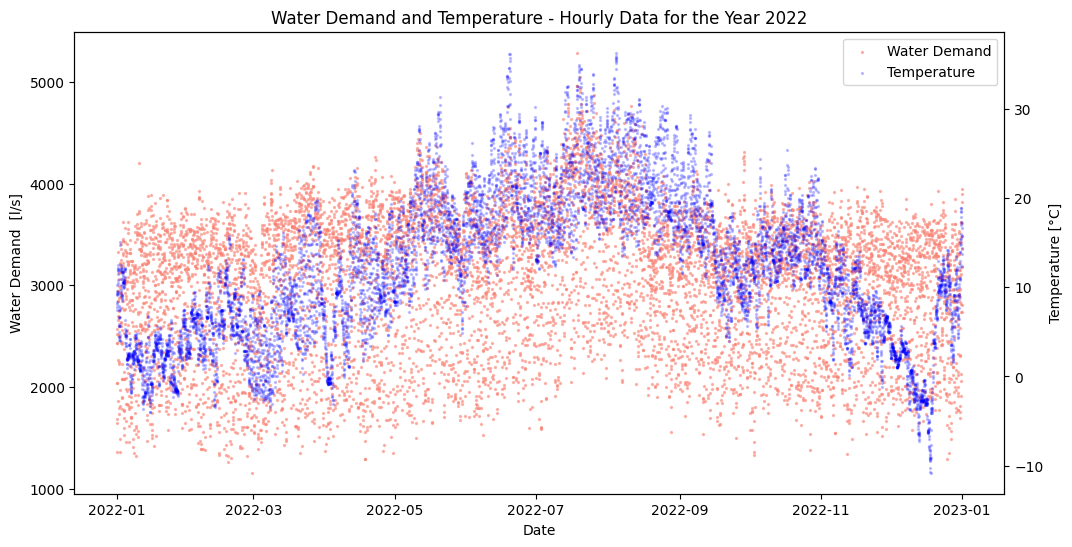

In [27]:
# Plot - Water Demand and Temperature
plt.style.use("default")

fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a label for the year
label = f"{start_date.year}"
scatter1 = ax1.scatter(
    year_data.index,
    year_data["nodal_demand"],
    s=2,  # Size of dots
    alpha=0.5,  # Transparency of dots
    label="Water Demand",
    color="salmon",
)

ax1.set_xlabel("Date")
ax1.set_ylabel("Water Demand  [l/s]")

# Create a second y-axis for the temperature
ax2 = ax1.twinx()
scatter2 = ax2.scatter(
    year_data.index,
    year_data["temperature_Schnar"],
    s=2,  # Size of dots
    alpha=0.2,  # Transparency of dots
    label="Temperature",
    color="blue",
)

ax2.set_ylabel("Temperature [°C]")
# Combine legends

scatters = [scatter1, scatter2]
labels = [scatter.get_label() for scatter in scatters]
ax1.legend(scatters, labels, loc="upper right")
plt.title(f"Water Demand and Temperature - Hourly Data for the Year {start_date.year}")
plt.show()

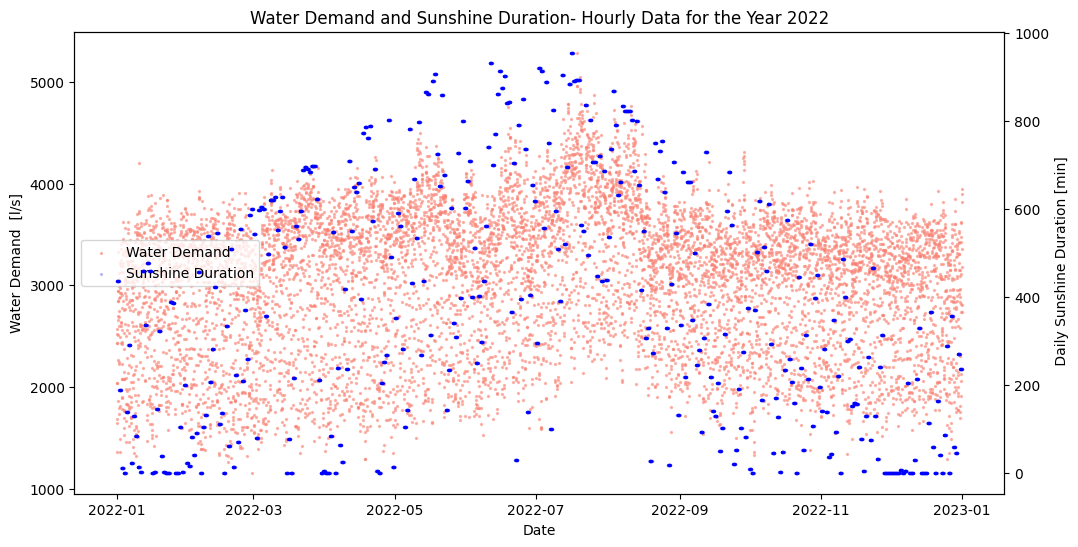

In [28]:
# Plot - Water Demand and Sunshine Duration
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a label for the year
label = f"{start_date.year}"
scatter1 = ax1.scatter(
    year_data.index,
    year_data["nodal_demand"],
    s=2,  # Size of dots
    alpha=0.5,  # Transparency of dots
    label="Water Demand",
    color="salmon",
)

ax1.set_xlabel("Date")
ax1.set_ylabel("Water Demand  [l/s]")

# Create a second y-axis for the sunshine duration

ax2 = ax1.twinx()
scatter2 = ax2.scatter(
    year_data.index,
    year_data["daily_sunshine_duration"],
    s=2,  # Size of dots
    alpha=0.2,  # Transparency of dots
    label="Sunshine Duration",
    color="blue",
)

ax2.set_ylabel(" Daily Sunshine Duration [min]")

# Add grid
# plt.grid(visible=True, linestyle="--", alpha=0.5)

# Combine legends
scatters = [scatter1, scatter2]
labels = [scatter.get_label() for scatter in scatters]
ax1.legend(scatters, labels, loc=6)

plt.title(
    f"Water Demand and Sunshine Duration- Hourly Data for the Year {start_date.year}"
)
plt.show()

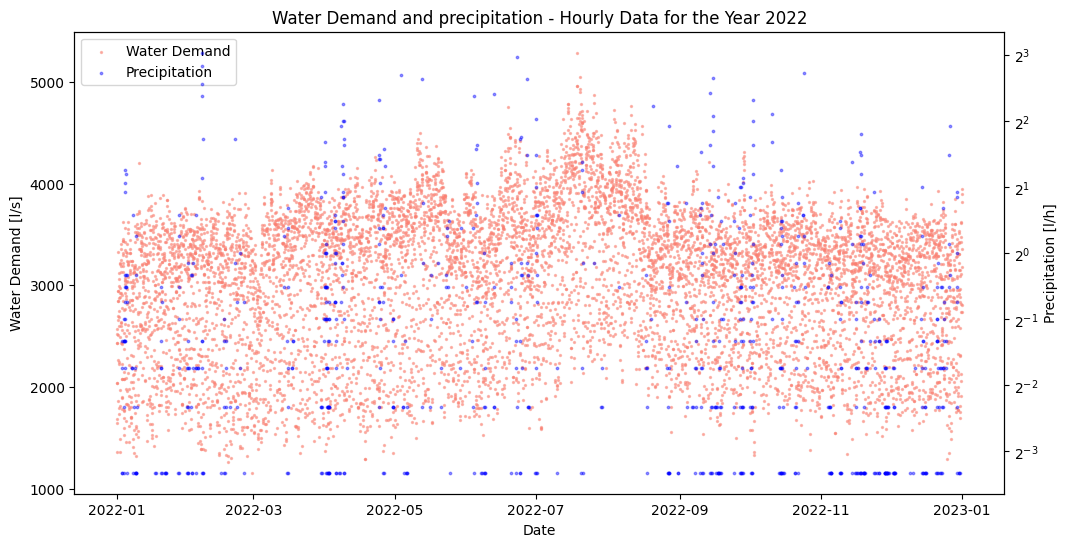

In [29]:
# Plot - Water Demand and Precipitation
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a label for the year
label = f"{start_date.year}"

scatter1 = ax1.scatter(
    year_data.index,
    year_data["nodal_demand"],
    s=2,  # Size of dots
    alpha=0.5,  # Transparency of dots
    label="Water Demand",
    color="salmon",
)

ax1.set_xlabel("Date")
ax1.set_ylabel("Water Demand [l/s]")

# Create a second y-axis for the temperature

ax2 = ax1.twinx()

scatter2 = ax2.scatter(
    year_data.index,
    year_data["precipitation_Schnar"],
    s=3,  # Size of dots
    alpha=0.4,  # Transparency of dots
    label="Precipitation",
    color="blue",
)

ax2.set_ylabel("Precipitation [l/h]")
ax2.set_yscale("log", base=2)  # Set log scale for the precipitation

# Combine legends
scatters = [scatter1, scatter2]
labels = [scatter.get_label() for scatter in scatters]
ax1.legend(scatters, labels, loc="upper left")
plt.title(
    f"Water Demand and precipitation - Hourly Data for the Year {start_date.year}"
)
plt.show()

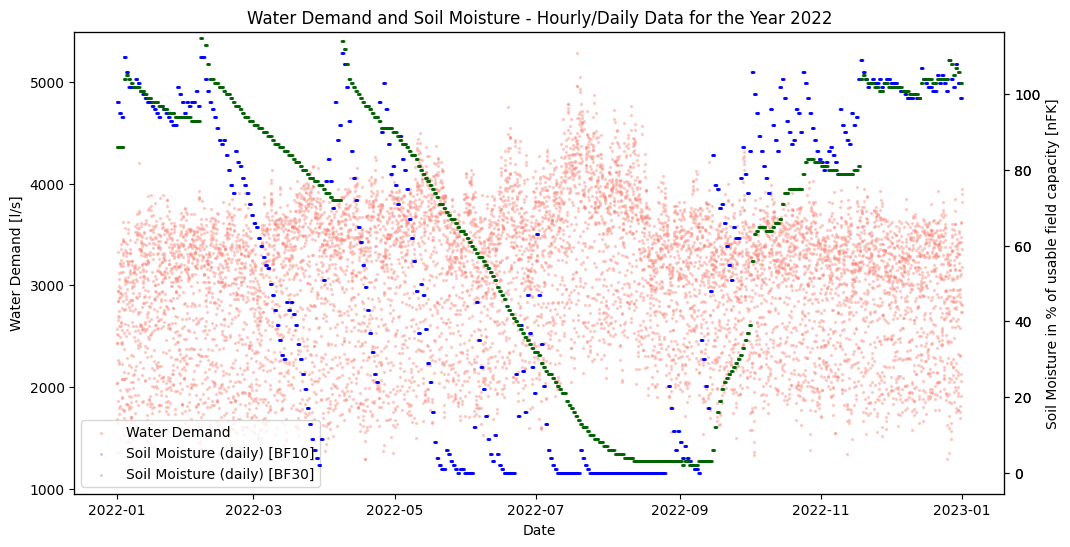

In [30]:
# Plot - Water Demand and Soil Moisture
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a label for the year
label = f"{start_date.year}"
scatter1 = ax1.scatter(
    year_data.index,
    year_data["nodal_demand"],
    s=2,  # Size of dots
    alpha=0.3,  # Transparency of dots
    label="Water Demand",
    color="salmon",
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Water Demand [l/s]")

# Create a second y-axis for the temperature

ax2 = ax1.twinx()
scatter2 = ax2.scatter(
    year_data.index,
    year_data["BF10"],
    s=1,  # Size of dots
    alpha=0.2,  # Transparency of dots
    label="Soil Moisture (daily) [BF10]",
    color="blue",
)
ax2.set_ylabel("Soil Moisture in % of usable field capacity [nFK]")

ax3 = ax1.twinx()
scatter3 = ax3.scatter(
    year_data.index,
    year_data["BF30"],
    s=1,  # Size of dots
    alpha=0.2,  # Transparency of dots
    label="Soil Moisture (daily) [BF30]",
    color="darkgreen",
)

ax3.set_xlim(ax2.get_xlim())
ax3.set_ylim(ax2.get_ylim())

# Combine legends

scatters = [scatter1, scatter2, scatter3]
labels = [scatter.get_label() for scatter in scatters]
ax1.legend(scatters, labels, loc="lower left")

plt.title(
    f"Water Demand and Soil Moisture - Hourly/Daily Data for the Year {start_date.year}"
)
plt.show()

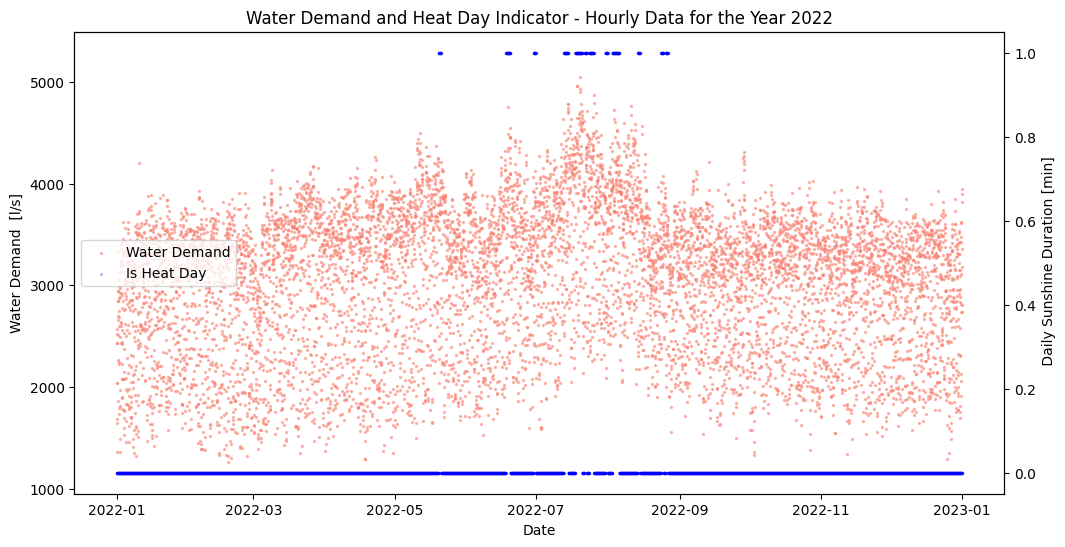

In [31]:
# Plot - Water Demand and Sunshine Duration
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a label for the year
label = f"{start_date.year}"
scatter1 = ax1.scatter(
    year_data.index,
    year_data["nodal_demand"],
    s=2,  # Size of dots
    alpha=0.5,  # Transparency of dots
    label="Water Demand",
    color="salmon",
)

ax1.set_xlabel("Date")
ax1.set_ylabel("Water Demand  [l/s]")

# Create a second y-axis for the sunshine duration

ax2 = ax1.twinx()
scatter2 = ax2.scatter(
    year_data.index,
    year_data["day_above_30"],
    s=2,  # Size of dots
    alpha=0.2,  # Transparency of dots
    label="Is Heat Day",
    color="blue",
)

ax2.set_ylabel(" Daily Sunshine Duration [min]")

# Combine legends
scatters = [scatter1, scatter2]
labels = [scatter.get_label() for scatter in scatters]
ax1.legend(scatters, labels, loc=6)

plt.title(
    f"Water Demand and Heat Day Indicator - Hourly Data for the Year {start_date.year}"
)
plt.show()

#### 2.2.) Short Term

In [153]:
start_date = "2023-06-26"
end_date = "2023-07-25"
short_term_df = df_merged[
    (df_merged.index >= start_date) & (df_merged.index < end_date)
]

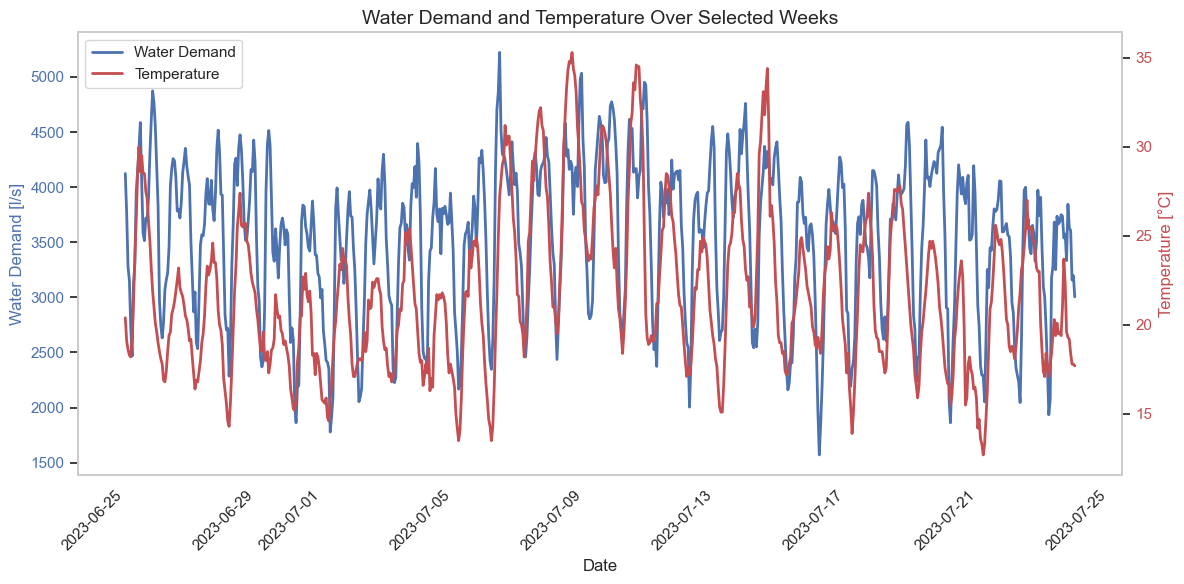

In [ ]:
# Plot - Water Demand for selected Weeks
sns.set(style="whitegrid")

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the nodal_demand
ax1.plot(
    short_term_df.index,
    short_term_df["nodal_demand"],
    label="Water Demand",
    color="b",
    linewidth=2,
)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Water Demand [l/s]", color="b", fontsize=12)
ax1.tick_params(axis="x", rotation=45)
ax1.tick_params(axis="y", labelcolor="b")

# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.plot(
    short_term_df.index,
    short_term_df["temperature_Schnar"],
    label="Temperature",
    color="r",
    linewidth=2,
)
ax2.set_ylabel("Temperature [°C]", color="r", fontsize=12)
ax2.tick_params(axis="y", labelcolor="r")

# Add grid
ax1.grid(visible=False)
ax2.grid(visible=False)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

# Add title
plt.title("Water Demand and Temperature Over Selected Weeks", fontsize=14)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [154]:
# Extract the hour and date from the timestamp
year_data["hour"] = year_data.index.hour
year_data["date"] = year_data.index.date


# Separate the data into working days and weekends
working_days = year_data.loc[year_data["is_weekend"] == False].copy()
weekends = year_data.loc[year_data["is_weekend"] == True].copy()
holidays = year_data.loc[year_data["is_holiday"] == True].copy()

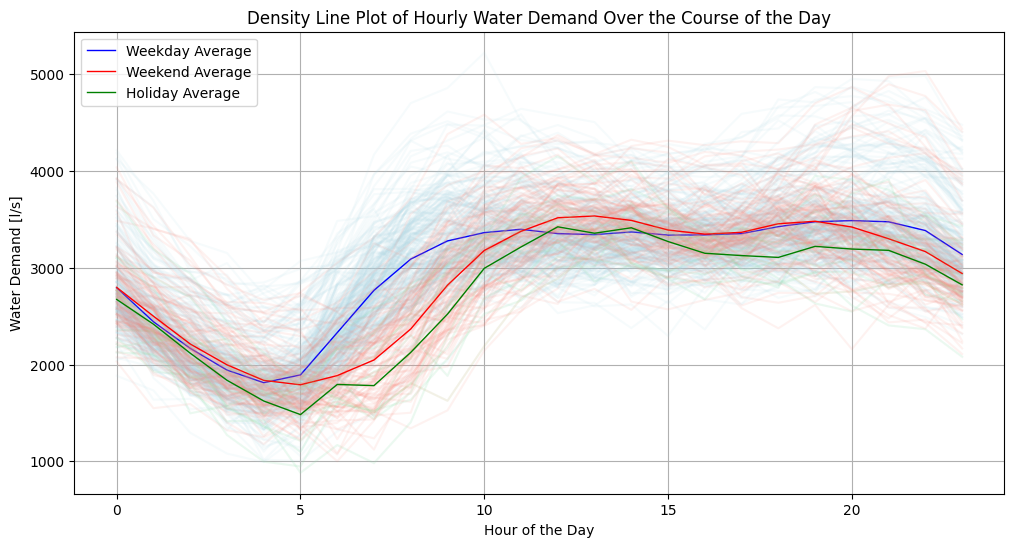

In [161]:
# Plot - Water Demand over the course of a Day
pivot_wd = (
    working_days.groupby(["date", "hour"])["nodal_demand"].mean().unstack(level="hour")
)
pivot_we = (
    weekends.groupby(["date", "hour"])["nodal_demand"].mean().unstack(level="hour")
)
pivot_ho = (
    holidays.groupby(["date", "hour"])["nodal_demand"].mean().unstack(level="hour")
)

plt.figure(figsize=(12, 6))

# Plot each weekday's daily line in a faint color
for day in pivot_wd.index:
    plt.plot(pivot_wd.columns, pivot_wd.loc[day], color="lightblue", alpha=0.1)

# Plot the average weekday demand line in thicker blue
avg_wd = pivot_wd.mean(axis=0)
plt.plot(pivot_wd.columns, avg_wd, color="blue", linewidth=1, label="Weekday Average")

# Plot each weekend day's daily line in a faint color
for day in pivot_we.index:
    plt.plot(pivot_we.columns, pivot_we.loc[day], color="salmon", alpha=0.1)

# Plot the average weekend demand line in thicker red
avg_we = pivot_we.mean(axis=0)
plt.plot(pivot_we.columns, avg_we, color="red", linewidth=1, label="Weekend Average")

# Plot each holiday daily line in a faint color
for day in pivot_ho.index:
    plt.plot(pivot_ho.columns, pivot_ho.loc[day], color="lightgreen", alpha=0.1)

# Plot the average holiday demand line in thicker red
avg_ho = pivot_ho.mean(axis=0)
plt.plot(pivot_ho.columns, avg_ho, color="green", linewidth=1, label="Holiday Average")

# Final styling
plt.xlabel("Hour of the Day")
plt.ylabel("Water Demand [l/s]")
plt.title("Density Line Plot of Hourly Water Demand Over the Course of the Day")
plt.legend()
plt.grid(True)
plt.show()

### 3.) SARIMA Model - One Day Ahead Forecast

#### 3.1.) Identifying the dependence orders of the model

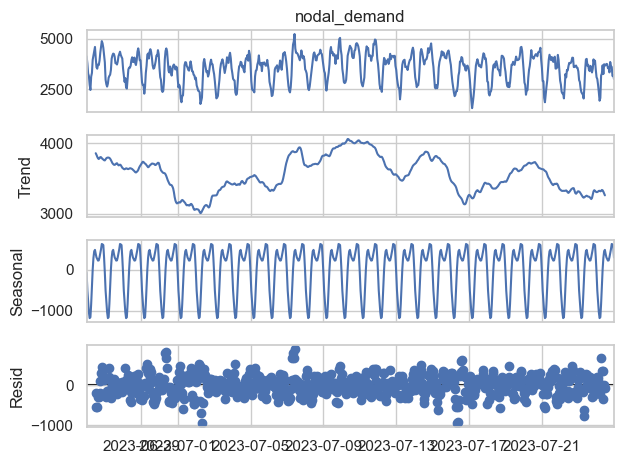

In [ ]:
# Decompose the selected weeks water demand
decomposition = seasonal_decompose(
    short_term_df["nodal_demand"], model="additive", period=24
)

decomposition.plot()

plt.show()

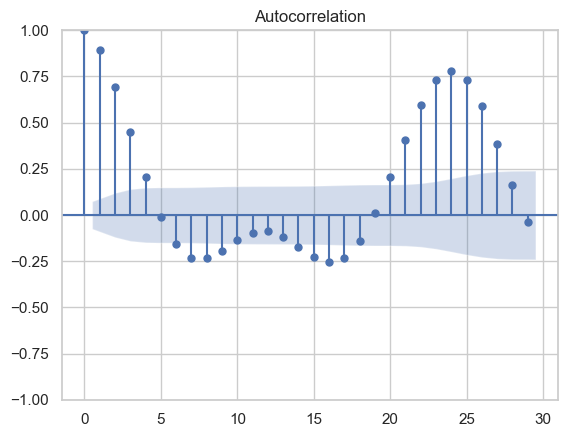

In [49]:
plot_acf(short_term_df["nodal_demand"])
plt.show()

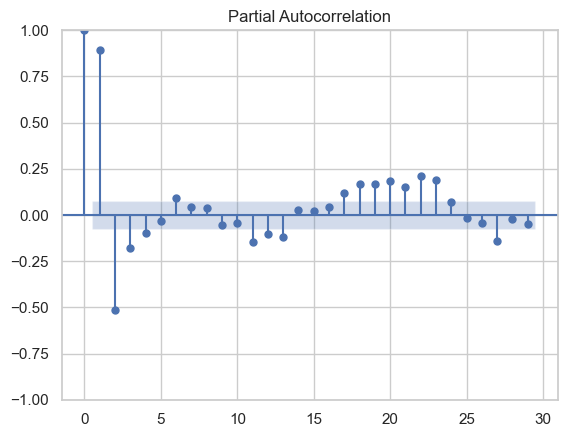

In [50]:
plot_pacf(short_term_df["nodal_demand"])
plt.show()

#### 3.2.) Fitting the Model

In [23]:
rolling_seven_day_forecast = []
for days in range(0, 7):
    train_start_date = pd.Timestamp(start_date) + pd.Timedelta(days=days)
    train_end_date = train_start_date + pd.Timedelta(days=14) - pd.Timedelta(hours=1)
    fc = train_and_forecast_sarima(short_term_df, train_start_date, train_end_date, 24)
    rolling_seven_day_forecast.append(fc)

order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4672.94
order: (1, 0, 1) x (2, 0, 0, 24) ; BIC: 4681.32
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4680.98
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4684.1
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4675.28
order: (1, 0, 1) x (2, 0, 0, 24) ; BIC: 4661.07
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4656.31


In [24]:
forecast = np.array(rolling_seven_day_forecast).flatten()
test_start_date = pd.Timestamp(start_date) + pd.Timedelta(days=14)
test_end_date = test_start_date + pd.Timedelta(days=7)
measured = filtered_df.loc[
    (filtered_df.index >= test_start_date) & (filtered_df.index < test_end_date),
    ["nodal_demand"],
]
error = measured["nodal_demand"] - forecast  # Calculate error

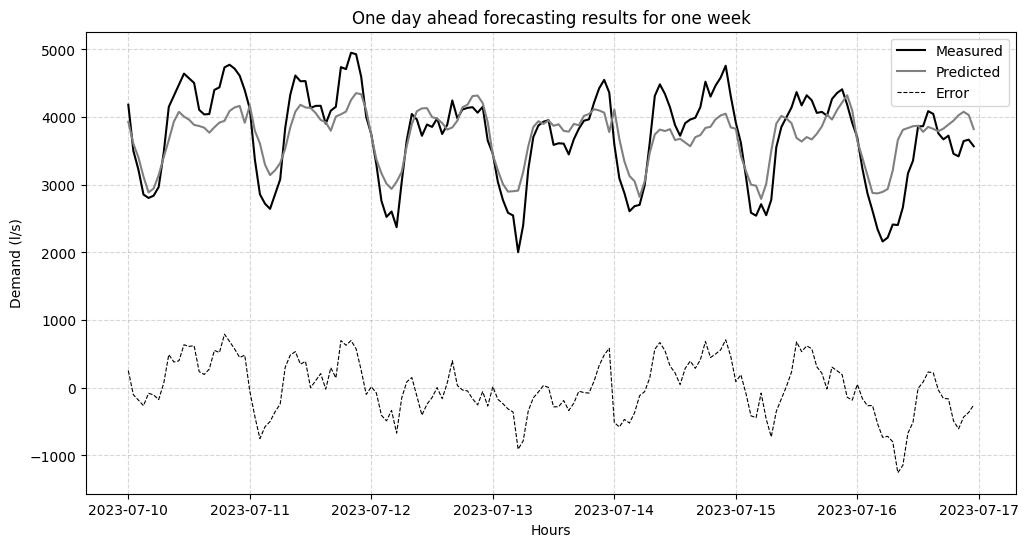

In [25]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot measured and predicted demand
plt.plot(measured.index, measured, label="Measured", color="black", linewidth=1.5)
plt.plot(measured.index, forecast, label="Predicted", color="gray", linewidth=1.5)

# Plot error
plt.plot(
    measured.index, error, label="Error", color="black", linestyle="--", linewidth=0.8
)

# Add labels, legend, and title
plt.xlabel("Date")
plt.ylabel("Water Demand [l/s]")
plt.title("One Day Ahead Forecasting Results for One Week - 07/2023")
plt.legend()

# Add grid
plt.grid(visible=True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()

### 4.) SARIMAX - Weather Based
Mid-term forecast based on exogoneous variables and time-serie decomposition

In [79]:
# Select 3 year period
start_date = pd.Timestamp("2021-01-01T00")

end_date = pd.Timestamp("2023-12-31T23")

sarimax_df = df_merged.loc[start_date:end_date].copy()

In [80]:
#  Prepare the data
endog = sarimax_df["nodal_demand"]
exog = sarimax_df[
    [
        # "T_hot",
        "T_hot^2",
        "is_weekend",
        "is_holiday",
        # "temperature_Schnar",
        # "dry_soil",
        "dry_soil_10*temperature_Schnar",
        # "dry_soil_30*temperature_Schnar",
        "dry_soil_10*T_hot",
        # "dry_soil_30*T_hot",
        # "precipitation_Schnar",
        # "T_hot*sunshine_duration_Schnar",
        # "T_hot*precipitation_Schnar",
        # "sin_168_1",
        # "cos_168_1",
        # "sin_168_2",
        # "cos_168_2",
        # "sin_168_3",
        # "cos_168_3",
    ]
]

# Split the data into training and testing sets (optional)
train_endog = endog[: 2 * 365 * 24]
test_endog = endog[2 * 365 * 24 + 1 :]
train_exog = exog[: 2 * 365 * 24]
test_exog = exog[2 * 365 * 24 + 1 :]

#### 4.1.) Determine model parameters

In [81]:
# Fit the SARIMAX model
model = SARIMAX(
    train_endog, exog=train_exog, order=(1, 0, 3), seasonal_order=(0, 1, 1, 24)
)
results = model.fit()
# Print the summary of the model
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         nodal_demand   No. Observations:                17520
Model:             SARIMAX(1, 0, 3)x(0, 1, [1], 24)   Log Likelihood             -117366.756
Date:                              Tue, 04 Feb 2025   AIC                         234755.511
Time:                                      10:37:40   BIC                         234840.978
Sample:                                  01-01-2021   HQIC                        234783.656
                                       - 12-31-2022                                         
Covariance Type:                                opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
T_hot                             39.6312     22.227      

In [82]:
# Make predictions one year ahead
predictions = results.get_forecast(steps=364 * 24 + 23, exog=test_exog)
predicted_mean = pd.DataFrame(predictions.predicted_mean).set_index(test_endog.index)

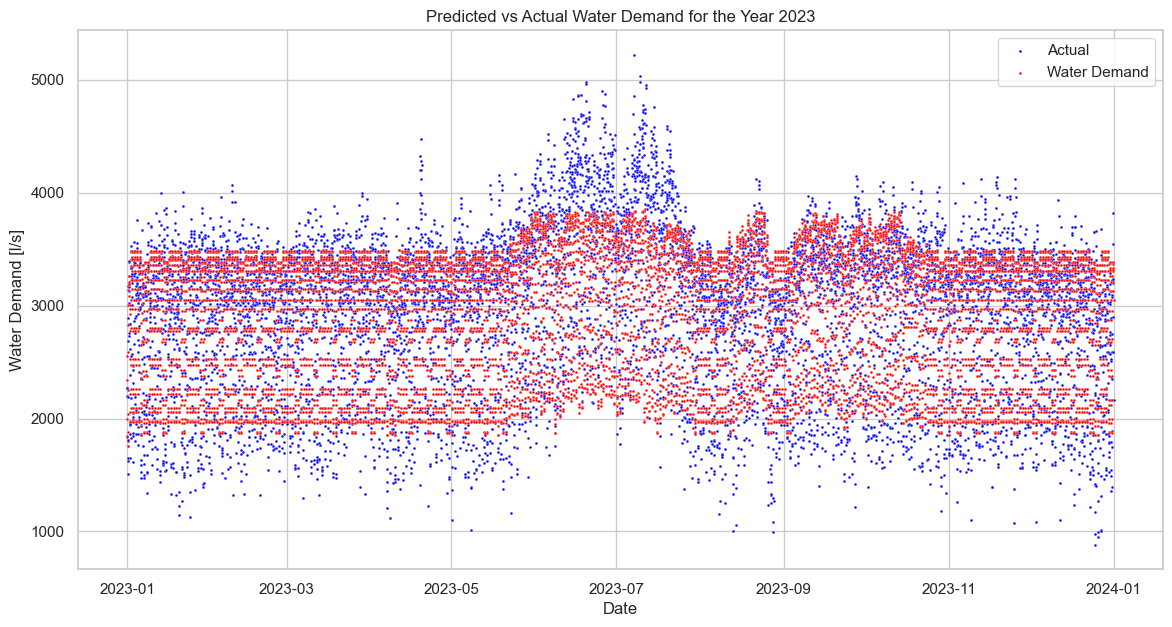

In [ ]:
# Plot - SARIMAX Forecast against Actual for 2023
plt.figure(figsize=(14, 7))
sns.scatterplot(
    x="datetime",
    y="nodal_demand",
    data=pd.DataFrame(test_endog),
    label="Actual",
    color="blue",
    s=4,
)
sns.scatterplot(
    x="datetime",
    y="predicted_mean",
    data=pd.DataFrame(predicted_mean),
    label="Water Demand",
    color="red",
    s=4,
)

plt.xlabel("Date")

plt.ylabel("Water Demand [l/s]")

plt.title("Predicted vs Actual Water Demand for the Year 2023")

plt.legend()

plt.show()

In [84]:
#  Calculate MSE
mse = mean_squared_error(test_endog, predicted_mean["predicted_mean"])

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(test_endog, predicted_mean["predicted_mean"])

# Calculate MAPE
mape = (
    np.mean(np.abs((test_endog - predicted_mean["predicted_mean"]) / test_endog)) * 100
)

# Create a DataFrame to display the results
results = pd.DataFrame(
    {"Metric": ["MSE", "RMSE", "MAE", "MAPE"], "Value": [mse, rmse, mae, mape]}
)

print(results)

  Metric          Value
0    MSE  200972.686034
1   RMSE     448.299773
2    MAE     349.476497
3   MAPE      12.697579


### 5.) Prophet
Open Source forecasting package provided by Meta

In [32]:
df_merged["date"] = df_merged.index

In [ ]:
# Set the dataframe
prophet_df = df_merged[
    [
        "date",
        "nodal_demand",
        "T_hot",
        "T_hot^2",
        "is_holiday",
        "day_above_30",
        "day_above_25",
        "dry_soil_10*temperature_Schnar",
        "dry_soil_10*T_hot",
        "dry_soil_10*day_above_25",
        "dry_soil_10*day_above_30",
    ]
].rename(columns={"date": "ds", "nodal_demand": "y"})


prophet_df.head(5)

ds            y  T_hot  T_hot^2  \
datetime                                                               
2017-01-01 00:00:00 2017-01-01 00:00:00  3108.049187    0.0      0.0   
2017-01-01 01:00:00 2017-01-01 01:00:00  2660.664133    0.0      0.0   
2017-01-01 02:00:00 2017-01-01 02:00:00  2733.942179    0.0      0.0   
2017-01-01 03:00:00 2017-01-01 03:00:00  1774.439187    0.0      0.0   
2017-01-01 04:00:00 2017-01-01 04:00:00  1963.201523    0.0      0.0   

                     is_holiday  day_above_30  day_above_25  \
datetime                                                      
2017-01-01 00:00:00           0             0             0   
2017-01-01 01:00:00           0             0             0   
2017-01-01 02:00:00           0             0             0   
2017-01-01 03:00:00           0             0             0   
2017-01-01 04:00:00           0             0             0   

                     dry_soil_10*temperature_Schnar  dry_soil_10*T_hot  \
datetime                                                                 
2017-01-01 00:00:00                             0.0               -0.0   
2017-01-01 01:00:00                             0.0               -0.0   
2017-01-01 02:00:00                             0.0               -0.0   
2017-01-01 03:00:00                             0.0               -0.0   
2017-01-01 04:00:00                             0.0               -0.0   

                     dry_soil_10*day_above_25  dry_soil_10*day_above_30  
datetime                                                                 
2017-01-01 00:00:00                      -0.0                      -0.0  
2017-01-01 01:00:00                      -0.0                      -0.0  
2017-01-01 02:00:00                      -0.0                      -0.0  
2017-01-01 03:00:00                      -0.0                      -0.0  
2017-01-01 04:00:00                      -0.0                      -0.0

In [ ]:
# Apply some filtering for extreme noise/anomalies
Q1 = prophet_df["y"].quantile(0.25)
Q3 = prophet_df["y"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.75 * IQR
upper_bound = Q3 + 1.75 * IQR
print("lower bound:", lower_bound, "\nupper bound:", upper_bound)
prophet_df.loc[
    (prophet_df["y"] < lower_bound) | (prophet_df["y"] > upper_bound), "y"
] = np.nan
print("number of values which will be interpolated:", prophet_df["y"].isna().sum())

lower bound: 910.0107796111115 
upper bound: 5320.949221861112
number of values which will be interpolated: 21


In [ ]:
# Initialize Prophet model
m = Prophet(
    changepoint_prior_scale=0.05,  # indicates the flexiblity to account for trend changes, something between 0.01 and 0.5, lower less flexible
    weekly_seasonality=True,
    yearly_seasonality=True,
    daily_seasonality=True,
    growth="flat",
    interval_width=0.95,  # confidence interval
)
m.add_regressor("T_hot")
m.add_regressor("T_hot^2")
m.add_regressor("is_holiday")
m.add_regressor("day_above_25")
m.add_regressor("day_above_30")
m.add_regressor("dry_soil_10*temperature_Schnar")
m.add_regressor("dry_soil_10*T_hot")
m.add_regressor("dry_soil_10*day_above_25")
m.add_regressor("dry_soil_10*day_above_30")

m.fit(prophet_df[: -365 * 24 * 2])

17:57:14 - cmdstanpy - INFO - Chain [1] start processing
17:57:17 - cmdstanpy - INFO - Chain [1] done processing


In [138]:
# Compute Forecast and Check Regressors
forecast = m.predict(
    prophet_df[
        [
            "ds",
            "T_hot",
            "T_hot^2",
            "is_holiday",
            "dry_soil_10*temperature_Schnar",
            "dry_soil_10*T_hot",
            "day_above_25",
            "day_above_30",
            "dry_soil_10*day_above_25",
            "dry_soil_10*day_above_30",
        ]
    ]
)
regressor_coefficients(m)

regressor regressor_mode      center  coef_lower  \
0                           T_hot       additive    0.139334   18.761200   
1                         T_hot^2       additive    0.649516    2.012137   
2                      is_holiday       additive    0.000000 -147.831196   
3                    day_above_25       additive    0.000000   96.232195   
4                    day_above_30       additive    0.000000  397.130781   
5  dry_soil_10*temperature_Schnar       additive  253.634851    0.356181   
6               dry_soil_10*T_hot       additive    5.434422   -0.936723   
7        dry_soil_10*day_above_25       additive    5.523811    1.117857   
8        dry_soil_10*day_above_30       additive    1.450986   -2.725597   

         coef  coef_upper  
0   18.761200   18.761200  
1    2.012137    2.012137  
2 -147.831196 -147.831196  
3   96.232195   96.232195  
4  397.130781  397.130781  
5    0.356181    0.356181  
6   -0.936723   -0.936723  
7    1.117857    1.117857  
8   -2.725597   -2.725597

#### 5.1.) Evaluation

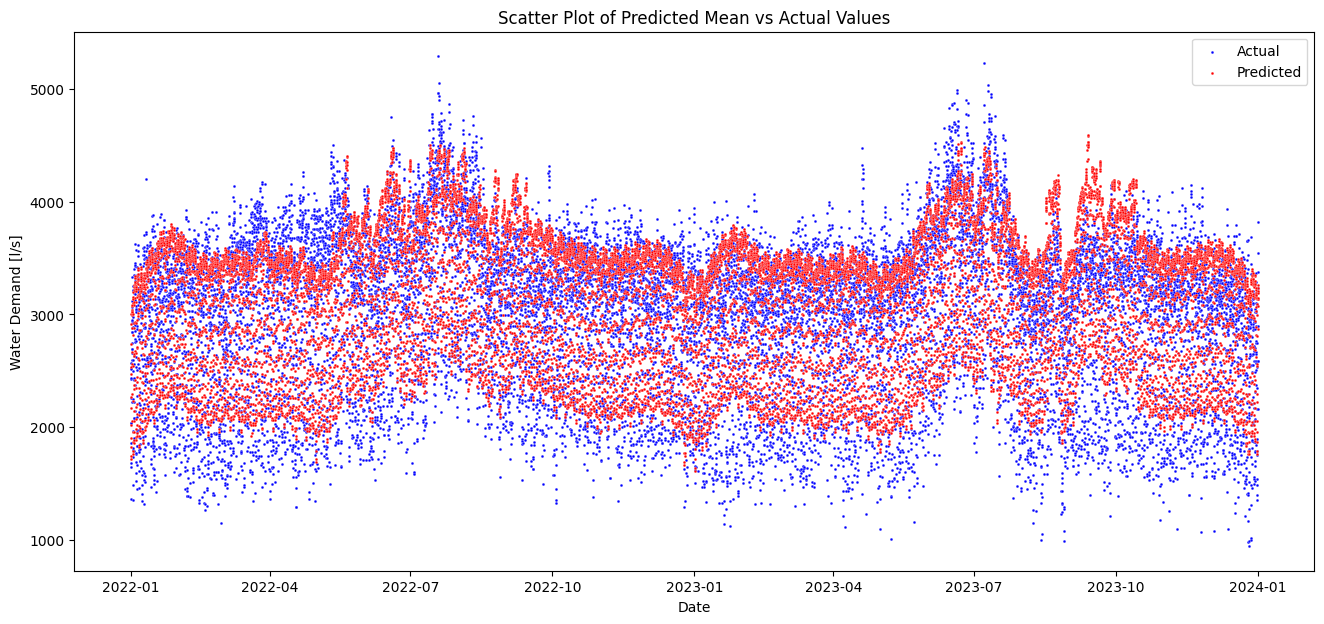

In [ ]:
# Visually evaluate forecast for the test year 2023
prophet_df["y_hat"] = forecast["yhat"].values  # create forecast column
plt.figure(figsize=(16, 7))

sns.scatterplot(
    x="ds",
    y="y",
    data=prophet_df[-365 * 24 * 2 :],
    label="Actual",
    color="blue",
    s=4,
)
sns.scatterplot(
    x="ds",
    y="y_hat",
    data=prophet_df[-365 * 24 * 2 :],
    label="Predicted",
    color="red",
    s=4,
)
plt.xlabel("Date")
plt.ylabel("Water Demand [l/s]")
plt.title("Scatter Plot of Predicted Mean vs Actual Values")
plt.legend()
plt.show()

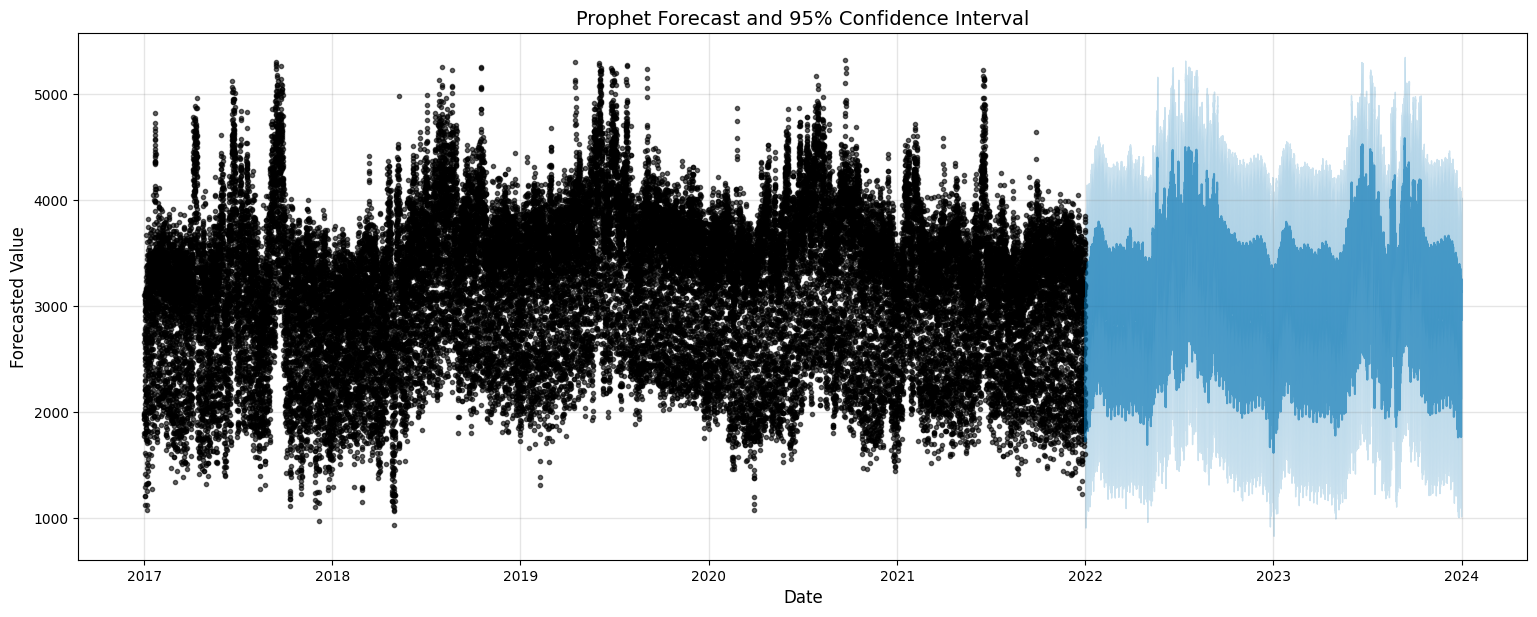

In [ ]:
# Plot forecast
fig = m.plot(forecast[-365 * 24 * 2 :])
fig.set_size_inches(16, 6)  # Width x Height
ax = fig.gca()  # Get current axes
# ax.collections[1].set_color("red")  # Change color of past data points
for line in ax.get_lines():
    line.set_alpha(0.6)  # Make lines less transparent

# Change uncertainty interval color
for collection in ax.collections:
    collection.set_alpha(0.2)  # Adjust confidence band transparency

plt.title("Prophet Forecast and 95% Confidence Interval", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Forecasted Value", fontsize=12)
plt.show()

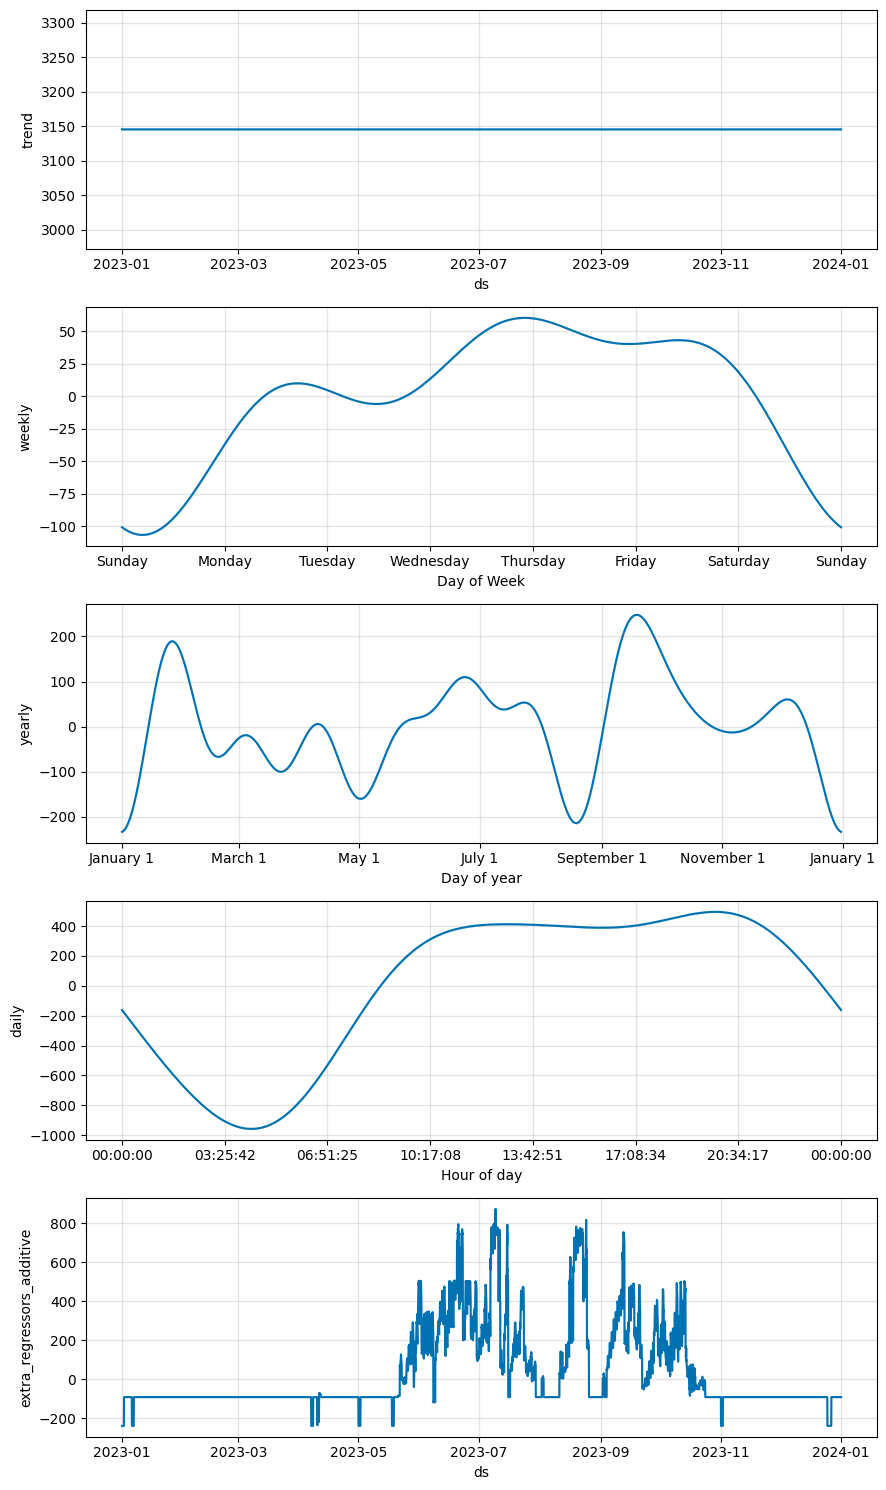

In [ ]:
# Slice 2023 forecast
forecast_2023 = forecast[forecast["ds"].dt.year == 2023]
# Decompose 2023 forecast


fig = m.plot_components(forecast_2023)

In [113]:
# Select 6 weeks of data to check for i week fit
week_indexes = [1, 12, 25, 30, 40, 50]
weeks = [prophet_df[-365 * 24 :].iloc[i * 168 : (i + 1) * 168] for i in week_indexes]

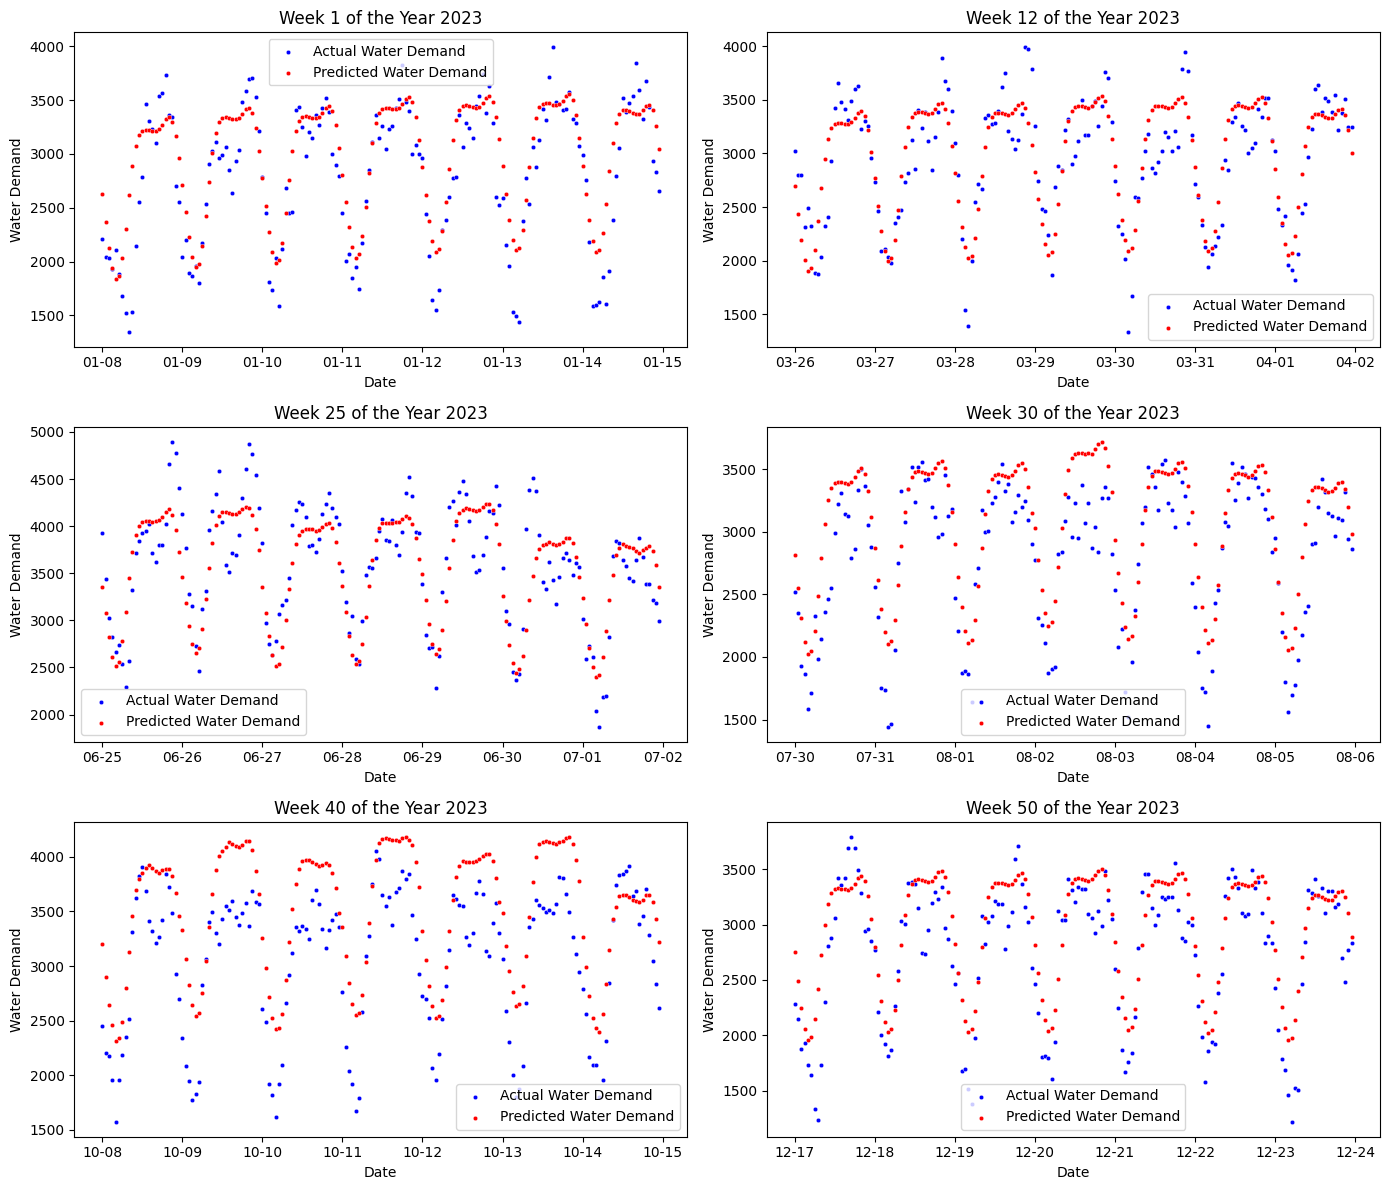

In [114]:
# Create the inweek plots for 6 selected weeks
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, week in enumerate(weeks):
    ax = axes[i // 2, i % 2]
    sns.scatterplot(
        x=week.index,
        y=week["y"],
        label="Actual Water Demand",
        color="blue",
        s=10,  # Size of dots
        ax=ax,
    )
    sns.scatterplot(
        x=week.index,
        y=week["y_hat"],
        label="Predicted Water Demand",
        color="red",
        s=10,  # Size of dots
        ax=ax,
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Water Demand")
    ax.set_title(f"Week {week_indexes[i]} of the Year 2023")
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))  # Format x-axis ticks

plt.tight_layout()
plt.show()

In [142]:
# Cross validate the model
df_cv = cross_validation(m, initial="1095 days", period="90 days", horizon="365 days")

  0%|          | 0/5 [00:00<?, ?it/s]

17:58:27 - cmdstanpy - INFO - Chain [1] start processing
17:58:28 - cmdstanpy - INFO - Chain [1] done processing
17:58:33 - cmdstanpy - INFO - Chain [1] start processing
17:58:35 - cmdstanpy - INFO - Chain [1] done processing
17:58:42 - cmdstanpy - INFO - Chain [1] start processing
17:58:43 - cmdstanpy - INFO - Chain [1] done processing
17:58:49 - cmdstanpy - INFO - Chain [1] start processing
17:58:51 - cmdstanpy - INFO - Chain [1] done processing
17:58:57 - cmdstanpy - INFO - Chain [1] start processing
17:58:59 - cmdstanpy - INFO - Chain [1] done processing


In [143]:
# Check perfomance metrics for selected forecasting horizons
df_p = performance_metrics(df_cv)  # create perfomance metric df

indices = [
    math.floor(i * len(df_p) / 10) for i in range(10)
]  # compute indices for 10 forecasting horizons


# Slice the DataFrame

df_p.iloc[indices]

horizon            mse        rmse         mae      mape  \
0     36 days 12:00:00  142046.984339  376.891210  298.824411  0.090856   
788   69 days 08:00:00  113486.324897  336.877314  261.452597  0.088472   
1577 102 days 05:00:00  106577.483963  326.462071  254.751758  0.088142   
2365 135 days 01:00:00  145687.860661  381.690792  301.893438  0.093147   
3154 167 days 22:00:00  111860.626787  334.455717  263.092312  0.090842   
3942 200 days 18:00:00  128342.757734  358.249575  281.365180  0.090507   
4731 233 days 15:00:00  139759.526476  373.844254  294.212125  0.095842   
5519 266 days 11:00:00  129974.126778  360.519246  285.563364  0.099298   
6308 299 days 08:00:00  136409.971542  369.337206  291.961263  0.099833   
7096 332 days 04:00:00  125854.583736  354.759896  274.717888  0.097657   

         mdape     smape  coverage  
0     0.076529  0.093389  0.959342  
788   0.068073  0.086800  0.974189  
1577  0.064690  0.084864  0.977159  
2365  0.078056  0.094868  0.956601  
3154  0.067861  0.086682  0.977615  
3942  0.071382  0.089136  0.967337  
4731  0.076418  0.094879  0.959799  
5519  0.075508  0.093646  0.966195  
6308  0.078251  0.096462  0.966651  
7096  0.072304  0.093615  0.964367

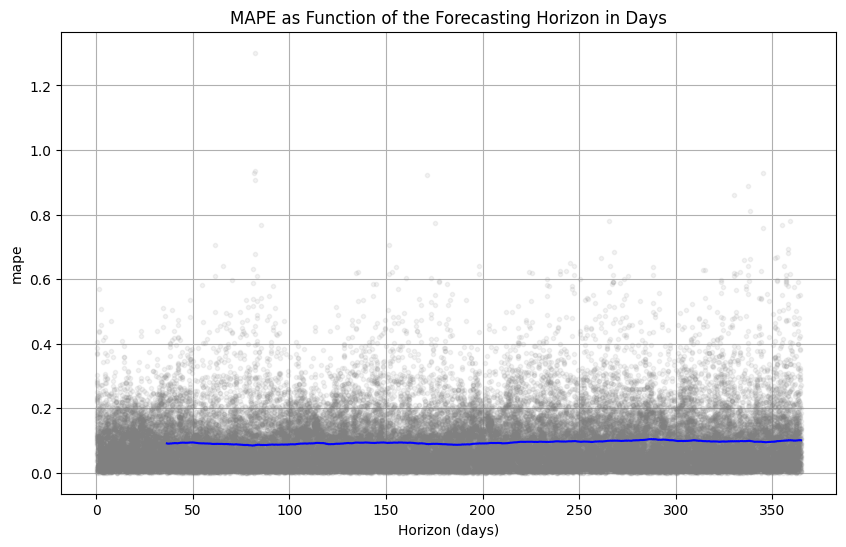

In [145]:
# Plot MAPE as function of forecasting horizon
fig = plot_cross_validation_metric(df_cv, metric="mape")
plt.title("MAPE as Function of the Forecasting Horizon in Days")
plt.show()